In [3]:
import os
import re
from collections import Counter
import string
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet
from nltk import pos_tag
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# import torch
# import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# import transformers
# from transformers import AutoModel, BertTokenizerFast

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras

# warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
# print(f"Using device: {device}, cuda: {use_cuda}")

In [5]:
coronaTweets = pd.read_csv('../00_source_data/CoronaTweet.csv', encoding='latin-1')
coronaTweets.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [6]:
# collapse sentiment to 3 categories
coronaTweets['Sentiment'] = coronaTweets['Sentiment'].map({'Extremely Negative': 'Negative', 'Negative': 'Negative', 'Neutral': 'Neutral', 'Positive': 'Positive', 'Extremely Positive': 'Positive'})
coronaTweets['Sentiment'].value_counts()

Positive    18046
Negative    15398
Neutral      7713
Name: Sentiment, dtype: int64

## Preprocessing

In [7]:
# define preprocessing function
def preprocess(text):

    # lowercase
    text = text.lower()
    # remove http links
    text = re.sub(r'http\S+', '', text)
    # remove hashtags
    text = re.sub(r'#\S+', '', text)
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # remove numbers
    text = re.sub(r'\d+', '', text)
    # only contain lowercaser 
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # remove stopwords
    text = ' '.join([word for word in text.split() if word not in (stopwords.words('english'))])
    # Stemming
    ps = PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])

    return text

In [8]:
coronaTweets['text'] = coronaTweets['OriginalTweet'].apply(preprocess)
coronaTweets.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,text
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,menyrbi philgahan chrisitv
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advic talk neighbour famili exchang phone numb...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronaviru australia woolworth give elderli di...
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,food stock one empti pleas dont panic enough f...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Negative,readi go supermarket outbreak im paranoid food...


In [34]:
# train test split
full_data = coronaTweets[['text', 'Sentiment']]
full_x = full_data['text'].values
full_y = full_data['Sentiment'].map({'Negative': 0, 'Neutral': 1, 'Positive': 2}).values
train_x, test_x, train_y, test_y = train_test_split(full_x, full_y, test_size=0.2, random_state=42)

In [35]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y_train = ohe.fit_transform(np.array(train_y).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(test_y).reshape(-1, 1)).toarray()

In [37]:
# define tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# tokenize
MAX_LEN = 128
def tokenize(text, max_len=MAX_LEN):
    input_ids = []
    attention_masks = []
    for sent in text:
        encoded_dict = tokenizer.encode_plus(
                            sent,                      
                            add_special_tokens = True, 
                            max_length = max_len,           
                            padding = 'max_length',
                            return_attention_mask = True,   
                       )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)


In [38]:
train_inputs, train_masks = tokenize(train_x, MAX_LEN)
test_inputs, test_masks = tokenize(test_x, MAX_LEN)

In [39]:
# Bert model
bert = TFBertModel.from_pretrained('bert-base-uncased')


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [40]:
def MyBertModel(bert, max_len = MAX_LEN):

    # parameters
    optimizer = keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    loss = keras.losses.CategoricalCrossentropy()
    metrics = keras.metrics.CategoricalAccuracy()

    # input layer
    input_ids = keras.Input(shape=(max_len,), dtype=tf.int32)
    attention_masks = keras.Input(shape=(max_len,), dtype='int32')
    embedding = bert([input_ids, attention_masks])[1]

    output = keras.layers.Dense(3, activation='softmax')(embedding)
    model = keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

In [41]:
model = MyBertModel(bert, max_len = MAX_LEN)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model_2 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_3[0][0]',                
                                thPoolingAndCrossAt               'input_4[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                         

In [42]:
history = model.fit([train_inputs, train_masks], y_train, validation_data=([test_inputs, test_masks], y_test), epochs=4, batch_size=32)

Epoch 1/4
1029/1029 [==============================] - 338s 313ms/step - loss: 0.6547 - categorical_accuracy: 0.7313 - val_loss: 0.5104 - val_categorical_accuracy: 0.8076
Epoch 2/4
1029/1029 [==============================] - 320s 311ms/step - loss: 0.4595 - categorical_accuracy: 0.8325 - val_loss: 0.4599 - val_categorical_accuracy: 0.8373
Epoch 3/4
1029/1029 [==============================] - 319s 310ms/step - loss: 0.3752 - categorical_accuracy: 0.8676 - val_loss: 0.4576 - val_categorical_accuracy: 0.8426
Epoch 4/4
1029/1029 [==============================] - 320s 311ms/step - loss: 0.3091 - categorical_accuracy: 0.8942 - val_loss: 0.4584 - val_categorical_accuracy: 0.8472


In [44]:
y_pred = np.zeros_like(model.predict([test_inputs,test_masks]))
y_pred[np.arange(len(y_pred)), model.predict([test_inputs,test_masks]).argmax(1)] = 1


258/258 [==============================] - 26s 100ms/step


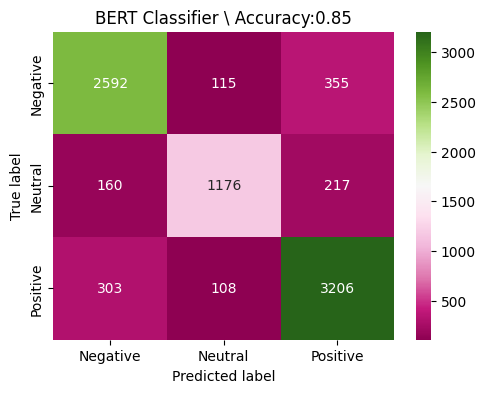

In [47]:
from sklearn.metrics import confusion_matrix, accuracy_score
# plot confusion matrix
cm = confusion_matrix(y_test.argmax(1), y_pred.argmax(1))
cm_df = pd.DataFrame(cm, index=['Negative', 'Neutral', 'Positive'], columns=['Negative', 'Neutral', 'Positive'])
plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, fmt='g', cmap="PiYG")
plt.title('BERT Classifier \ Accuracy:{0:.2f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')

# save plot to file
plt.savefig('../30_results/BERT_real_data.png')